###**Table of Content**

A few questions to be investigated suggested by the framework:

*   **Part I**: Battery Consumption and Output and Profitability
*   **Part II**: Correlation between renewable availability and market prices is crucial in explaining the profitability of renewables and storage
*   **Part III**: Wind and Solar vs Battery (complement or substitute)
*   **Part IV**: Logit model for predicting profitability


#### **Context**:
While conventional wisdom suggests that
1. Storage technologies, such as batteries, provide an effective solution for shifting supply from periods with abundant renewable energy to those when it is relatively scarce.
2. Renewable energies enlarge price differences across time due to their volatility, strengthening arbitrage opportunities for storage firms
3. Storage reduces the curtailment of renewable energy by absorbing excess production when it exceeds demand

It is possible that
1. Storage and renewable investments are not always
complementary due to price effect
2. *Storage does not always help shift the supply (charge when renewable production is high but demand is low and discharge when renewable is low but demand is high, but rather compete with renewables). It's possible that battery is discharging even when renewable ready to meet the demand becuase renewables pushes up the price and battery discharge to follow the price thuse competing with renewable output)* - **how do we prove this**

In [1]:
!pip install linearmodels > /dev/null
!pip install tabulate > /dev/null
!pip install pyspark > /dev/null

import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import gdown
import gspread
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from linearmodels import OLS
from tabulate import tabulate
from scipy.optimize import leastsq
from scipy.stats import linregress  # Import linregress from scipy.stats
from sklearn.metrics import confusion_matrix
warnings.filterwarnings("ignore")

### Data prep

In [2]:
# Google Drive file ID
file_id = "1ZcMUM4LrxzXtvrTqRtstKNvKLt8IiaKm"

# Modified URL to download the file
url = f"https://drive.google.com/uc?id={file_id}"

# Read the CSV file directly into a DataFrame
org_df = pd.read_csv(url)

org_df.head()

# Cleaning Type 1
# Drop outliers
dates_to_drop = ['2019-10-02', '2019-10-01', '2018-09-22', '2018-09-21']
df1 = org_df[~org_df['date'].isin(dates_to_drop)]

# Replace negative or zero values in 'solar' and 'wind' columns with 0
df1.loc[org_df['solar'] <= 0, 'solar'] = 0
df1.loc[org_df['wind'] <= 0, 'wind'] = 0

# Cleaning Type 2
df2 = org_df[(org_df['solar'] >= 0) & (org_df['wind'] >= 0)]

In [3]:
columns = df2.columns.tolist()
print(columns)

['date', 'hour', 'solar', 'wind', 'geothermal', 'biomass', 'biogas', 'smallhydro', 'coal', 'nuclear', 'naturalgas', 'largehydro', 'battery', 'imports', 'other', 'battery_pos', 'battery_neg', 'load_dayaheadfc', 'load_houraheadfc', 'load_realized', 'renewables', 'price_DAM', 'price_RTM']


In [4]:
num_observations_DAM = df2['price_DAM'].count()
num_observations_RTM = df2['price_RTM'].count()

print(f"Number of observations in 'price_DAM': {num_observations_DAM}")
print(f"Number of observations in 'price_RTM': {num_observations_RTM}")

Number of observations in 'price_DAM': 28057
Number of observations in 'price_RTM': 22410


In [5]:
# Set df
df = df1
#df = df2

# Generate dummy variables for fix effects
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter
df['year'] = df['date'].dt.year

day_of_week_dummies = pd.get_dummies(df['date'].dt.dayofweek, prefix='day_of_week')
month_dummies = pd.get_dummies(df['date'].dt.month, prefix='month')
quarter_dummies = pd.get_dummies(df['date'].dt.quarter, prefix='quarter')
year_dummies = pd.get_dummies(df['date'].dt.year, prefix='year')
hour_dummies = pd.get_dummies(df['hour'], prefix='hour')

df = pd.concat([df, day_of_week_dummies, month_dummies, quarter_dummies, year_dummies, hour_dummies], axis=1)

# Generate new variables
df['solar_wind'] = df['solar'] + df['wind']
df['renewable_percentage'] = df['solar_wind'] / df['load_realized']
df['battery_consumption'] = df['battery'].apply(lambda x: abs(x) if x < 0 else 0)
df['battery_output'] = df['battery'].apply(lambda x: x if x > 0 else 0)
df['battery_cost'] = df['battery_consumption'] * df['price_DAM']
df['battery_revenue'] = df['battery_output'] * df['price_DAM']
df['profit'] = df['battery_revenue'] - df['battery_cost']
df['profiting'] = (df['battery_revenue'] > df['battery_cost']).astype(int)

### **Part I** Battery Consumption and Output: data exploration


1.   Battery profit jumped up in mid 2020 while the increase renewable capacity was steady and gradual during 2018-2022
2.   Battery was indeed benefiting from the arbitrage: output increase as price increase, and battery consumption increase as price decrease
3.  Battery profit mirrors the price curve and battery consumption mirrors renewable production



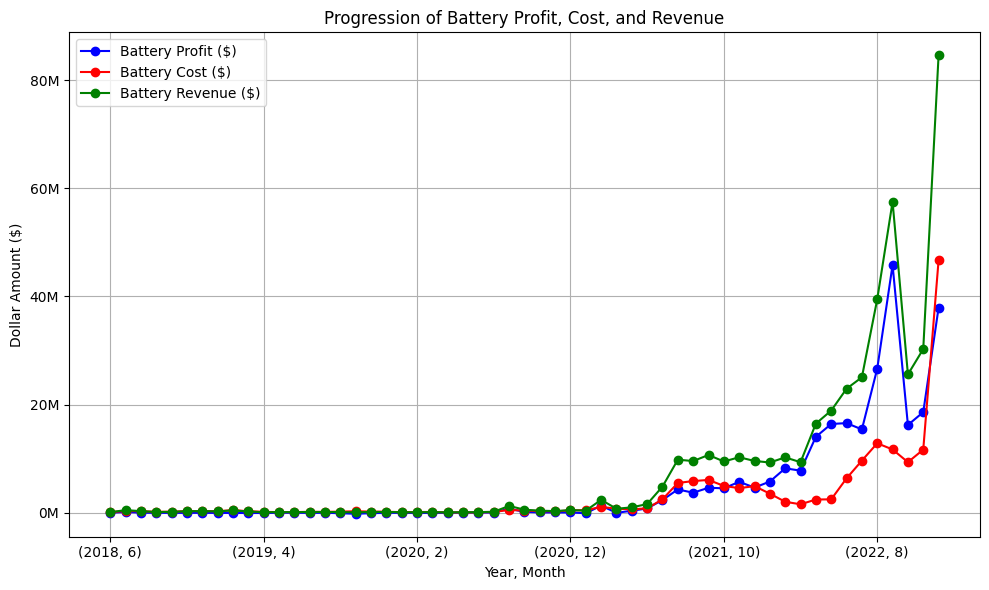

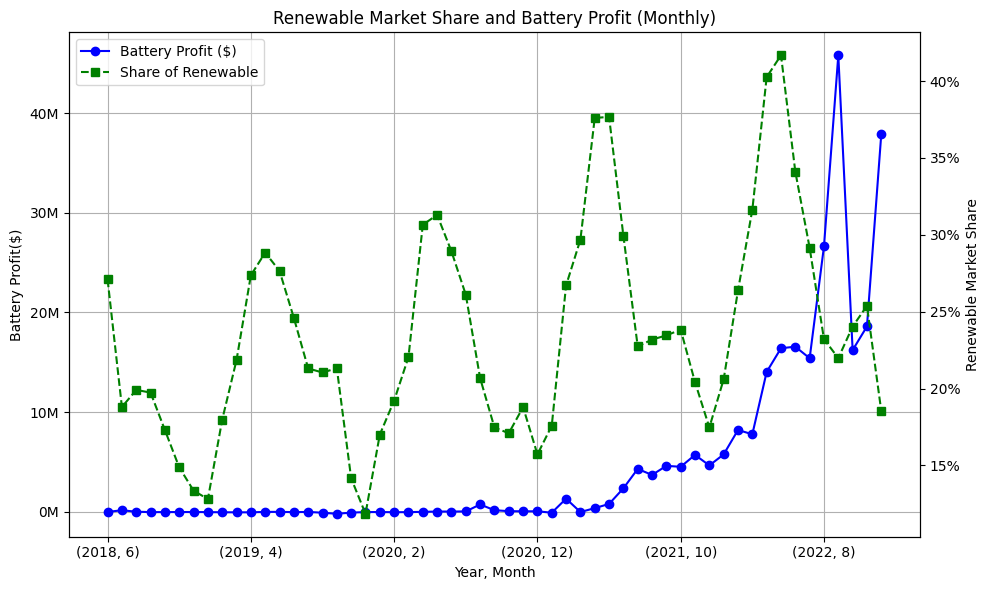

In [6]:
import matplotlib.ticker as ticker  # Corrected import statement
# Group by year and month_of_yr and calculate the total bat_profit, bat_cost, and bat_revenue for each month
monthly_profit = df.groupby(['year', 'month'])['profit'].sum()
monthly_cost = df.groupby(['year', 'month'])['battery_cost'].sum()
monthly_revenue = df.groupby(['year', 'month'])['battery_revenue'].sum()

# Plot the monthly bat_profit, bat_cost, and bat_revenue along the timeline
plt.figure(figsize=(10, 6))
monthly_profit.plot(kind='line', marker='o', color='blue', label='Battery Profit ($)')
monthly_cost.plot(kind='line', marker='o', color='red', label='Battery Cost ($)')
monthly_revenue.plot(kind='line', marker='o', color='green', label='Battery Revenue ($)')
plt.title('Progression of Battery Profit, Cost, and Revenue')
plt.xlabel('Year, Month')
plt.ylabel('Dollar Amount ($)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x / 1e6)}M'))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Group by year and month and calculate the total profit and renewable capacity for each month
monthly_profit = df.groupby(['year', 'month'])['profit'].sum()
monthly_renewable_capacity = df.groupby(['year', 'month'])['renewable_percentage'].mean()

# Plot the monthly profit and renewable capacity along the timeline
fig, ax1 = plt.subplots(figsize=(10, 6))

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Plot monthly profit using the left axis
monthly_profit.plot(kind='line', marker='o', color='blue', label='Battery Profit ($)', ax=ax1)
ax1.set_xlabel('Year, Month')
ax1.set_ylabel('Battery Profit($)', color='black')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x / 1e6)}M'))
ax1.tick_params(axis='y', labelcolor='black')

# Create a secondary y-axis for renewable capacity
ax2 = ax1.twinx()
monthly_renewable_capacity.plot(kind='line', marker='s', linestyle='--', color='green', label='Share of Renewable', ax=ax2)
ax2.set_ylabel('Renewable Market Share', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Format the secondary y-axis to display percentages
ax2.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

# Add legend and grid
lines = ax1.get_lines() + ax2.get_lines()
ax1.legend(lines, [line.get_label() for line in lines], loc='upper left')
ax1.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout and show plot
plt.title('Renewable Market Share and Battery Profit (Monthly)')
plt.tight_layout()
plt.show()


#### I b)Battery profit, price, and renewable availability

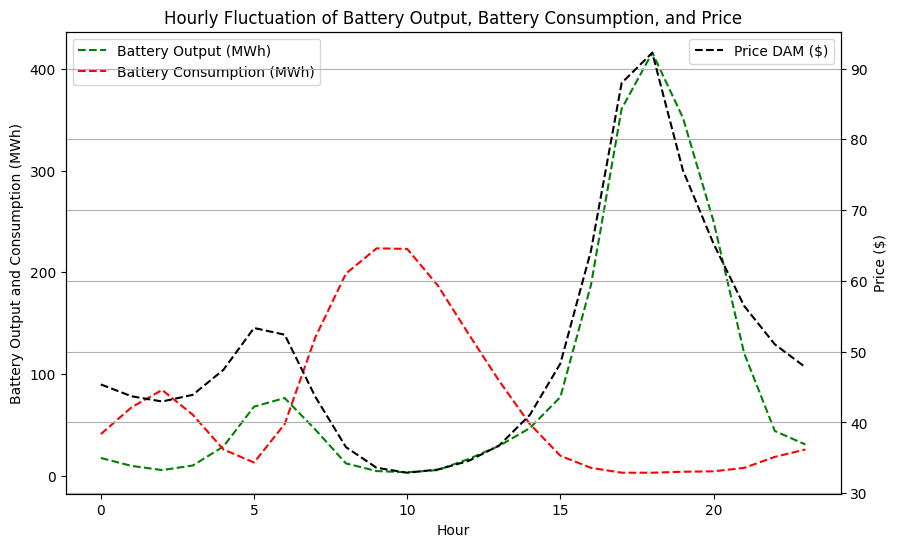

In [7]:
# Group by 'hour' and calculate the mean for each hour
hourly_mean = df.groupby('hour').mean().reset_index()

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot wind and solar on primary y-axis
ax1.plot(hourly_mean['hour'], hourly_mean['battery_output'], color='green', linestyle='--', label='Battery Output (MWh)')
ax1.set_xlabel('Hour')
ax1.plot(hourly_mean['hour'], hourly_mean['battery_consumption'], color='red', linestyle='--', label='Battery Consumption (MWh)')
ax1.set_ylabel('Battery Output and Consumption (MWh)')

# Create secondary y-axis for price_DAM
ax2 = ax1.twinx()
ax2.plot(hourly_mean['hour'], hourly_mean['price_DAM'], color='black', linestyle='--', label='Price DAM ($)')
ax2.set_ylabel('Price ($)')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Set title and labels
plt.title('Hourly Fluctuation of Battery Output, Battery Consumption, and Price')
plt.xlabel('Hour')

# Show plot
plt.grid(True)
plt.show()


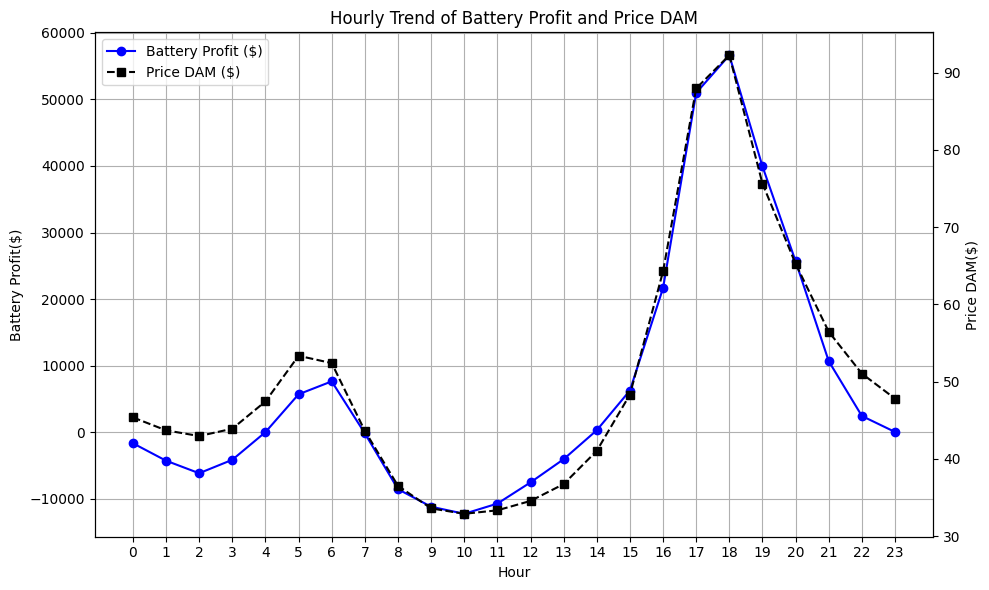

In [8]:
# Calculate the mean battery profit for each hour
hourly_mean_profit = df.groupby('hour')['profit'].mean().reset_index()

# Calculate the mean price_DAM for each hour
hourly_mean_price_DAM = df.groupby('hour')['price_DAM'].mean().reset_index()

# Plot the mean battery profit over hours
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot mean battery profit
ax1.plot(hourly_mean_profit['hour'], hourly_mean_profit['profit'], marker='o', linestyle='-', color='b', label='Battery Profit ($)')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Battery Profit($)', color='black')
ax1.tick_params('y', colors='black')
ax1.grid(True)

# Create a secondary y-axis for price_DAM
ax2 = ax1.twinx()
ax2.plot(hourly_mean_price_DAM['hour'], hourly_mean_price_DAM['price_DAM'], marker='s', linestyle='--', color='black', label='Price DAM ($)')
ax2.set_ylabel('Price DAM($)', color='black')
ax2.tick_params('y', colors='black')

# Show legend
lines = ax1.get_lines() + ax2.get_lines()
ax1.legend(lines, [line.get_label() for line in lines], loc='upper left')

# Set x-axis ticks to show all hours
ax1.set_xticks(hourly_mean_profit['hour'])

# Adjust layout
plt.title('Hourly Trend of Battery Profit and Price DAM')
plt.tight_layout()
plt.show()


Battery already discharging while renewable still outputing

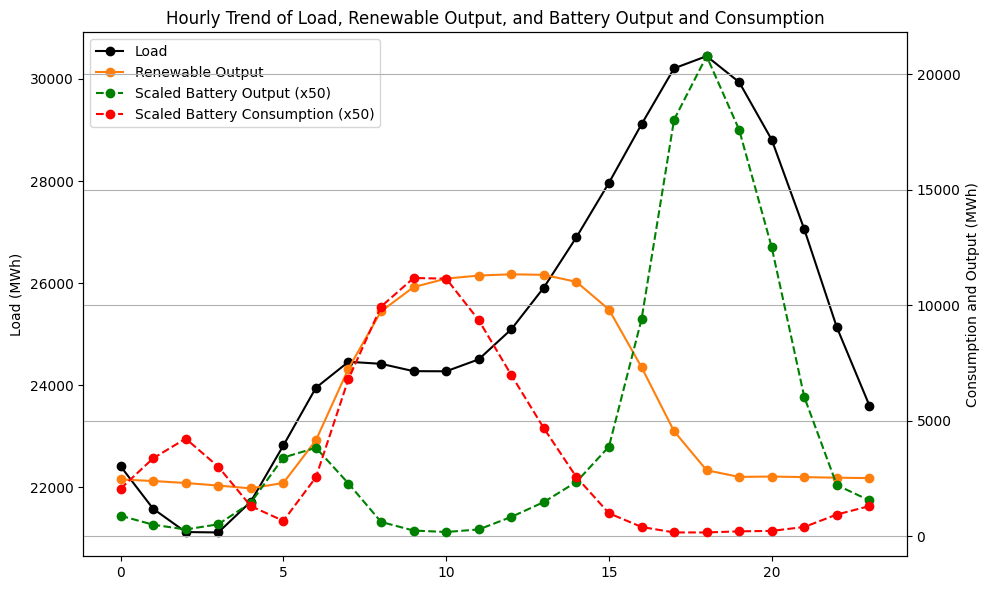

In [9]:
import matplotlib.pyplot as plt

# Calculate the hourly average of solar and wind
hourly_avg_load = hourly_mean['load_dayaheadfc']
hourly_avg_renewable = hourly_mean['solar_wind']
hourly_avg_output = hourly_mean['battery_output']
hourly_avg_consumption = hourly_mean['battery_consumption']

# Plot the mean battery consumption and solar + wind over hours
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Load on the left y-axis
ax1.plot(hourly_mean['hour'], hourly_avg_load, marker='o', linestyle='-', color='black', label='Load')
ax1.set_ylabel('Load (MWh)', color='black')
ax1.tick_params(axis='y', colors='black')

# Create the first secondary y-axis for solar + wind
ax2 = ax1.twinx()
ax2.plot(hourly_mean['hour'], hourly_avg_renewable, marker='o', linestyle='-', color='tab:orange', label='Renewable Output')
ax2.set_ylabel('Consumption and Output (MWh)', color='black')
ax2.tick_params(axis='y', colors='black')

# Scale battery output and consumption for plotting on the same secondary y-axis
scale_factor = 50  # Adjust this scaling factor as needed
scaled_output = hourly_avg_output * scale_factor
scaled_consumption = hourly_avg_consumption * scale_factor

# Plot scaled battery output and consumption on the same secondary y-axis
ax2.plot(hourly_mean['hour'], scaled_output, marker='o', linestyle='--', color='green', label='Scaled Battery Output (x50)')
ax2.plot(hourly_mean['hour'], scaled_consumption, marker='o', linestyle='--', color='red', label='Scaled Battery Consumption (x50)')

# Add legends to the plot
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Adjust layout
plt.title('Hourly Trend of Load, Renewable Output, and Battery Output and Consumption')
plt.grid(True)
plt.tight_layout()
plt.show()


### **Part II**: Correlation between renewable availability and market prices

1. Correlation between renewable output and market price is largely negative: correlation between wind and price is negative, which sets the background for wind and storage being complement
2. Solar, unlike expected, was not procyclical, which sets the background for solar and storage being complement rather substitute as well.

In [10]:
df = df.dropna(subset=['price_DAM'])

# Add constant column to the DataFrame
df['const'] = 1

# Define fixed effects
fixed_effects = ['day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                 'day_of_week_5', 'day_of_week_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
                 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'quarter_1',
                 'quarter_2', 'quarter_3', 'quarter_4', 'year_2018', 'year_2019', 'year_2020', 'year_2021',
                 'year_2022', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
                 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
                 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23']
df[fixed_effects] = df[fixed_effects].astype(float)

# List to store results
results = []

# Loop through each hour
for hour in range(24):
    # Filter DataFrame for current hour
    df_hour = df[df['hour_{}'.format(hour)] == 1]

    # Define independent and dependent variables
    X = df_hour[['const', 'wind'] + fixed_effects]
    y = df_hour['price_DAM']

    # Fit the regression model with fixed effects
    model = sm.OLS(y, X).fit()

    # Store results
    coef_wind = model.params['wind']
    std_err_wind = model.bse['wind']
    p_value_wind = model.pvalues['wind']

    # Determine significance level
    if p_value_wind < 0.01:
        significance = '***'
    elif p_value_wind < 0.05:
        significance = '**'
    elif p_value_wind < 0.1:
        significance = '*'
    else:
        significance = ''

    # Append coefficient and std err to results list
    results.append((coef_wind, std_err_wind, significance))

# Print summary for each hour
for hour, result in enumerate(results):
    print(f"Summary for Hour {hour}:")
    print(result)


Summary for Hour 0:
(-0.0018387298113085788, 0.000625366943401185, '***')
Summary for Hour 1:
(-0.001785336455888898, 0.0006102272470134403, '***')
Summary for Hour 2:
(-0.0017661643306239965, 0.0006008867261768907, '***')
Summary for Hour 3:
(-0.0017363385783792623, 0.0005988418939109557, '***')
Summary for Hour 4:
(-0.0015926202344665609, 0.0006211085812144036, '**')
Summary for Hour 5:
(-0.002026796290661597, 0.0007191879433285752, '***')
Summary for Hour 6:
(-0.002361414169303173, 0.0008444568899278706, '***')
Summary for Hour 7:
(-0.0021914007171066553, 0.0007855716961702743, '***')
Summary for Hour 8:
(-0.0022312327646280303, 0.000649031390779075, '***')
Summary for Hour 9:
(-0.0025511067115179774, 0.0005980475506838566, '***')
Summary for Hour 10:
(-0.0029705910735175547, 0.000569094435640908, '***')
Summary for Hour 11:
(-0.0032880242868140656, 0.0005496051358982438, '***')
Summary for Hour 12:
(-0.003678373994188672, 0.0005342993742408924, '***')
Summary for Hour 13:
(-0.00410

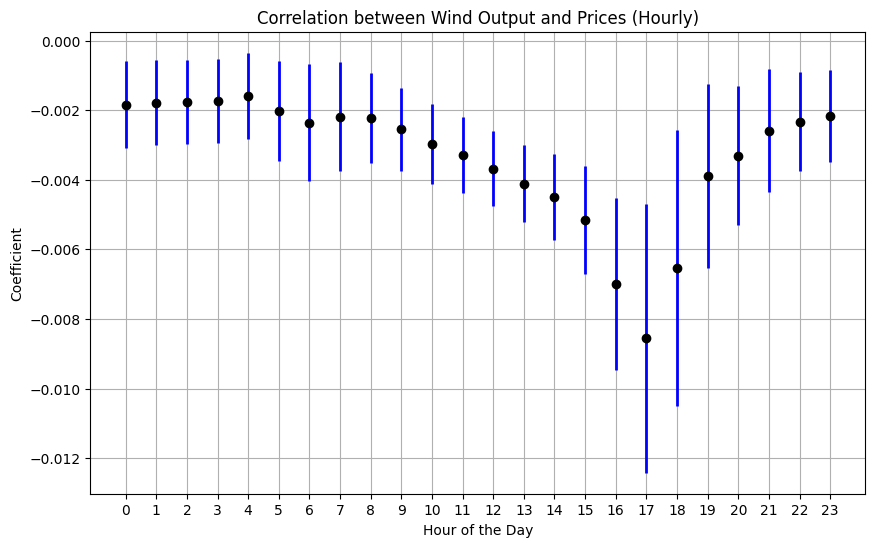

In [11]:
# Extracting data for plotting
hours = list(range(24))
coef_winds = [result[0] for result in results]
std_errs = [result[1]*2 for result in results]

# Create candlestick chart
plt.figure(figsize=(10, 6))
plt.errorbar(hours, coef_winds, yerr=std_errs, fmt='o', color='black', ecolor='blue', elinewidth=2, capsize=0)
plt.title("Correlation between Wind Output and Prices (Hourly)")
plt.xlabel("Hour of the Day")
plt.ylabel("Coefficient")
plt.grid(True)
plt.xticks(hours)
plt.show()


In [12]:
day_df = df[(df['hour'] >= 7) & (df['hour'] <= 17)] #get rid of the hours where there's no production

# Get the minimum and maximum hour from day_df
min_hour = day_df['hour'].min()
max_hour = day_df['hour'].max()

# List to store results
results = []

# Loop through each hour
for hour in range(min_hour, max_hour + 1):
    # Filter DataFrame for current hour
    df_hour = day_df[day_df['hour'] == hour]

    # Define independent and dependent variables
    X = df_hour[['const', 'solar'] + fixed_effects]
    y = df_hour['price_DAM']

    # Fit the regression model with fixed effects
    model = sm.OLS(y, X).fit()

    # Store results
    coef_solar = model.params['solar']
    std_err_solar = model.bse['solar']
    p_value_solar = model.pvalues['solar']

    # Determine significance level
    if p_value_wind < 0.01:
        significance = '***'
    elif p_value_wind < 0.05:
        significance = '**'
    elif p_value_wind < 0.1:
        significance = '*'
    else:
        significance = ''

    # Append coefficient and std err to results list
    results.append((hour, coef_solar, std_err_solar, significance))

# Print summary for each hour
for result in results:
    hour = result[0]
    coef_solar = result[1]
    std_err_solar = result[2]

    print(f"Summary for Hour {hour}:")
    print(f"Coefficient of 'solar': {coef_solar}, Std Err: {std_err_solar}, Significance: {significance}")

Summary for Hour 7:
Coefficient of 'solar': -0.004661633201399475, Std Err: 0.0006349644287342788, Significance: ***
Summary for Hour 8:
Coefficient of 'solar': -0.0034338385910204555, Std Err: 0.0004452839093307417, Significance: ***
Summary for Hour 9:
Coefficient of 'solar': -0.002914649268105108, Std Err: 0.00041474786310936754, Significance: ***
Summary for Hour 10:
Coefficient of 'solar': -0.0025542355584601316, Std Err: 0.0004395611852369259, Significance: ***
Summary for Hour 11:
Coefficient of 'solar': -0.0023984857581422093, Std Err: 0.0004645762888196903, Significance: ***
Summary for Hour 12:
Coefficient of 'solar': -0.0023347374505859764, Std Err: 0.00046133092194306896, Significance: ***
Summary for Hour 13:
Coefficient of 'solar': -0.002803338172249566, Std Err: 0.00045786834213239354, Significance: ***
Summary for Hour 14:
Coefficient of 'solar': -0.003467249367938671, Std Err: 0.0004853213898683505, Significance: ***
Summary for Hour 15:
Coefficient of 'solar': -0.0051

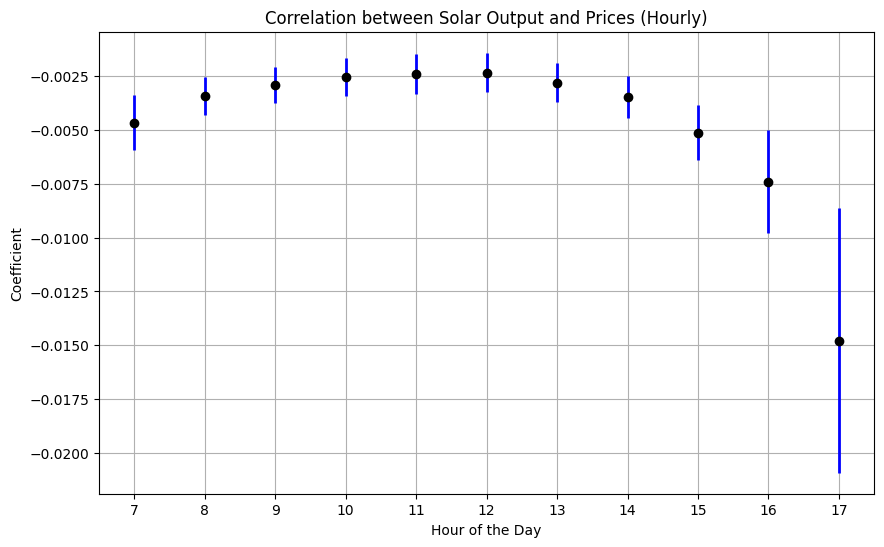

In [13]:
import matplotlib.pyplot as plt

# Extracting data for plotting
hours = [result[0] for result in results]
coef_solars = [result[1] for result in results]
std_errs = [result[2] * 2 for result in results]  # Multiply by 2 to get the range for the candlestick chart

# Create candlestick chart
plt.figure(figsize=(10, 6))
plt.errorbar(hours, coef_solars, yerr=std_errs, fmt='o', color='black', ecolor='blue', elinewidth=2, capsize=0)
plt.title("Correlation between Solar Output and Prices (Hourly)")
plt.xlabel("Hour of the Day")
plt.ylabel("Coefficient")
plt.grid(True)
plt.xticks(hours)
plt.show()

### **Part III**: Wind and Solar vs Battery (complement or substitute)


1.   Both wind and solar output are significantly negatively correlated with battery output and revenue/profit
2.   Despite the negative correlateion bewteen wind/solar and price, the countercyclical nature (output high while price low) does not lead to a complementary relationship between the renewables and battery




In [14]:
from tabulate import tabulate

# Define the DataFrame and variables
dependent_variables = ['battery', 'battery_output', 'battery_consumption']
independent_variables = ['wind', 'solar']
control_variables = ['coal', 'nuclear']
# Remove fixed effects variables from the dictionary
fixed_effects = ['day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                     'day_of_week_5', 'day_of_week_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
                     'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'quarter_1',
                     'quarter_2', 'quarter_3', 'quarter_4', 'year_2018', 'year_2019', 'year_2020', 'year_2021',
                     'year_2022', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
                     'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
                     'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23']

# Initialize an empty dictionary to store the results
results_dict = {}

# Loop through each dependent variable
for dep_var in dependent_variables:
    # Create the OLS model
    model = sm.OLS(day_df[dep_var], day_df[independent_variables + control_variables + fixed_effects])

    # Fit the model
    result = model.fit()

    # Create a dictionary to store the coefficients, standard errors, significance, R-squared, and N for the current dependent variable
    coef_stderr_significance_dict = {}

    # Append the coefficients, standard errors, and significance for each variable
    for var in independent_variables + control_variables:
        coef = result.params[var]
        stderr = result.bse[var]
        p_value = result.pvalues[var]
        if p_value < 0.01:
            significance = '***'
        elif p_value < 0.05:
            significance = '**'
        elif p_value < 0.1:
            significance = '*'
        else:
            significance = ''
        coef_stderr_significance_dict[var] = f"{coef:.7f}{significance}\n({stderr:.7f})"

    # Add R-squared and N to the dictionary
    coef_stderr_significance_dict['R-squared'] = result.rsquared
    coef_stderr_significance_dict['N'] = result.nobs

    # Add the results for the current dependent variable to the dictionary
    results_dict[dep_var] = coef_stderr_significance_dict

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(results_dict)

# Print the DataFrame
print(tabulate(results_df, headers='keys', tablefmt='pipe'))

#####################################################################
#####################################################################

control_variables = ['coal', 'nuclear','load_dayaheadfc']

# Initialize an empty dictionary to store the results
results_dict = {}

# Loop through each dependent variable
for dep_var in dependent_variables:
    # Create the OLS model
    model = sm.OLS(day_df[dep_var], day_df[independent_variables + control_variables + fixed_effects])

    # Fit the model
    result = model.fit()

    # Create a dictionary to store the coefficients, standard errors, significance, R-squared, and N for the current dependent variable
    coef_stderr_significance_dict = {}

    # Append the coefficients, standard errors, and significance for each variable
    for var in independent_variables + control_variables:
        coef = result.params[var]
        stderr = result.bse[var]
        p_value = result.pvalues[var]
        if p_value < 0.01:
            significance = '***'
        elif p_value < 0.05:
            significance = '**'
        elif p_value < 0.1:
            significance = '*'
        else:
            significance = ''
        coef_stderr_significance_dict[var] = f"{coef:.7f}{significance}\n({stderr:.7f})"

    # Add R-squared and N to the dictionary
    coef_stderr_significance_dict['R-squared'] = result.rsquared
    coef_stderr_significance_dict['N'] = result.nobs

    # Add the results for the current dependent variable to the dictionary
    results_dict[dep_var] = coef_stderr_significance_dict

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(results_dict)

# Print the DataFrame
print()
print("Added load")
print(tabulate(results_df, headers='keys', tablefmt='pipe'))


|           | battery            | battery_output     | battery_consumption   |
|:----------|:-------------------|:-------------------|:----------------------|
| wind      | -0.0134602***      | -0.0128171***      | 0.0006430             |
|           | (0.0021543)        | (0.0012476)        | (0.0013570)           |
| solar     | -0.0473442***      | -0.0286315***      | 0.0187128***          |
|           | (0.0015976)        | (0.0009251)        | (0.0010063)           |
| coal      | -0.3774172         | -1.7366589***      | -1.3592417***         |
|           | (0.5503767)        | (0.3187230)        | (0.3466924)           |
| nuclear   | -0.0231495***      | 0.0177292***       | 0.0408788***          |
|           | (0.0057033)        | (0.0033028)        | (0.0035926)           |
| R-squared | 0.2590819502597672 | 0.3843351862714768 | 0.391583756768779     |
| N         | 18315.0            | 18315.0            | 18315.0               |

Added load
|                 | battery 

In [15]:
# Calculate the average of the specified columns
average_battery = df['battery'].mean()
average_battery_output = df['battery_output'].mean()
average_battery_consumption = df['battery_consumption'].mean()

# Print the average values
print("Average battery level:", average_battery)
print("Average battery output:", average_battery_output)
print("Average battery consumption:", average_battery_consumption)


Average battery level: 22.1045280468574
Average battery output: 92.53635703737078
Average battery consumption: 70.43182899051338


"*Consequently, wind and storage are complements, while in the case of solar,
this is true only if there is enough solar capacity. Otherwise, solar and storage investments
substitute each other from the investors’ point of view.*"

**Even though we were able to confirm a negative correlation bewteen price and wind availability from the previous section, we do not see wind and storage being complements. The above regression shows a consistent substitution effect for both wind vs battery output and solar vs battery output**


In [16]:
day_df = df[(df['hour'] >= 7) & (df['hour'] <= 17)] #get rid of the hours where there's no production

# Define the DataFrame and variables
dependent_variables = ['profit', 'battery_revenue', 'battery_cost']
independent_variables = ['wind', 'solar']
control_variables = ['coal', 'nuclear']
# Remove fixed effects variables from the dictionary
fixed_effects = ['day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                     'day_of_week_5', 'day_of_week_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
                     'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'quarter_1',
                     'quarter_2', 'quarter_3', 'quarter_4', 'year_2018', 'year_2019', 'year_2020', 'year_2021',
                     'year_2022', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
                     'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
                     'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23']

# Initialize an empty dictionary to store the results
results_dict = {}

# Loop through each dependent variable
for dep_var in dependent_variables:
    # Create the OLS model
    model = sm.OLS(day_df[dep_var], day_df[independent_variables + control_variables + fixed_effects])

    # Fit the model
    result = model.fit()

    # Create a dictionary to store the coefficients, standard errors, and significance for the current dependent variable
    coef_stderr_significance_dict = {}

    # Append the coefficients, standard errors, and significance for each variable
    for var in independent_variables + control_variables:
        coef = result.params[var]
        stderr = result.bse[var]
        p_value = result.pvalues[var]
        if p_value < 0.01:
            significance = '***'
        elif p_value < 0.05:
            significance = '**'
        elif p_value < 0.1:
            significance = '*'
        else:
            significance = ''
        coef_stderr_significance_dict[var] = f"{coef:.7f}{significance}\n({stderr:.7f})"
        # Add R-squared and N to the dictionary
    coef_stderr_significance_dict['R-squared'] = result.rsquared
    coef_stderr_significance_dict['N'] = result.nobs

    # Add the results for the current dependent variable to the dictionary
    results_dict[dep_var] = coef_stderr_significance_dict

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(results_dict)

# Print the DataFrame
print(tabulate(results_df, headers='keys', tablefmt='pipe'))

#####################################################################
#####################################################################

control_variables = ['coal', 'nuclear','load_dayaheadfc']

# Initialize an empty dictionary to store the results
results_dict = {}

# Loop through each dependent variable
for dep_var in dependent_variables:
    # Create the OLS model
    model = sm.OLS(day_df[dep_var], day_df[independent_variables + control_variables + fixed_effects])

    # Fit the model
    result = model.fit()

    # Create a dictionary to store the coefficients, standard errors, and significance for the current dependent variable
    coef_stderr_significance_dict = {}

    # Append the coefficients, standard errors, and significance for each variable
    for var in independent_variables + control_variables:
        coef = result.params[var]
        stderr = result.bse[var]
        p_value = result.pvalues[var]
        if p_value < 0.01:
            significance = '***'
        elif p_value < 0.05:
            significance = '**'
        elif p_value < 0.1:
            significance = '*'
        else:
            significance = ''
        coef_stderr_significance_dict[var] = f"{coef:.7f}{significance}\n({stderr:.7f})"

    coef_stderr_significance_dict['R-squared'] = result.rsquared
    coef_stderr_significance_dict['N'] = result.nobs

    # Add the results for the current dependent variable to the dictionary
    results_dict[dep_var] = coef_stderr_significance_dict

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(results_dict)

# Print the DataFrame
print()
print("Added load")
print(tabulate(results_df, headers='keys', tablefmt='pipe'))


|           | profit              | battery_revenue    | battery_cost        |
|:----------|:--------------------|:-------------------|:--------------------|
| wind      | -2.2916359***       | -2.7022045***      | -0.4105686***       |
|           | (0.3871384)         | (0.3393287)        | (0.1454363)         |
| solar     | -5.4006650***       | -4.2503785***      | 1.1502865***        |
|           | (0.2870874)         | (0.2516335)        | (0.1078501)         |
| coal      | -253.8818241**      | -684.5696985***    | -430.6878745***     |
|           | (98.9050727)        | (86.6907821)       | (37.1556717)        |
| nuclear   | -1.0382337          | 3.1493064***       | 4.1875400***        |
|           | (1.0249142)         | (0.8983423)        | (0.3850296)         |
| R-squared | 0.10913048174155016 | 0.1563365741952497 | 0.21912482036015868 |
| N         | 18315.0             | 18315.0            | 18315.0             |

Added load
|                 | profit              

Battery profit and battery revenue are also negatively correlated with wind and solar output

In [17]:
# Calculate the average of the specified columns
average_battery = df['profit'].mean()
average_battery_output = df['battery_revenue'].mean()
average_battery_consumption = df['battery_cost'].mean()

# Print the average values
print("Average battery  profit:", average_battery)
print("Average battery revenue:", average_battery_output)
print("Average battery cost:", average_battery_consumption)


Average battery  profit: 6561.423443718555
Average battery revenue: 10698.412530349678
Average battery cost: 4136.989086631123


### Coefficient by hours

In [18]:
# Define the DataFrame and variables
dependent_variables = ['battery', 'battery_output', 'battery_consumption']
independent_variables = ['wind', 'solar']
control_variables = ['coal', 'nuclear']
# Remove fixed effects variables from the dictionary
fixed_effects = ['day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                     'day_of_week_5', 'day_of_week_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
                     'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'quarter_1',
                     'quarter_2', 'quarter_3', 'quarter_4', 'year_2018', 'year_2019', 'year_2020', 'year_2021',
                     'year_2022', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
                     'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
                     'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23']

# Initialize an empty dictionary to store the results
all_results = {}

# Loop through each dependent variable
for hour in range(8, 17):
    # Filter DataFrame for the current hour
    df_hour = day_df[day_df['hour'] == hour]

    # Initialize an empty dictionary to store the results for the current hour
    results_dict = {}

    # Loop through each dependent variable
    for dep_var in dependent_variables:
        # Create the OLS model
        model = sm.OLS(df_hour[dep_var], df_hour[independent_variables + control_variables + fixed_effects])

        # Fit the model
        result = model.fit()

        # Create a dictionary to store the coefficients, standard errors, and significance for the current dependent variable
        coef_stderr_significance_dict = {}

        # Append the coefficients, standard errors, and significance for each variable
        for var in independent_variables:
            coef = result.params[var]
            stderr = result.bse[var]
            p_value = result.pvalues[var]
            if p_value < 0.01:
                significance = '***'
            elif p_value < 0.05:
                significance = '**'
            elif p_value < 0.1:
                significance = '*'
            else:
                significance = ''
            coef_stderr_significance_dict[var] = f"{coef:.7f}{significance}\n({stderr:.7f})"

        # Add R-squared and N to the dictionary
        coef_stderr_significance_dict['R-squared'] = result.rsquared
        coef_stderr_significance_dict['N'] = result.nobs

        # Add the results for the current dependent variable to the dictionary
        results_dict[dep_var] = coef_stderr_significance_dict

    # Store results for the current hour in the main dictionary
    all_results[f'Hour_{hour}'] = results_dict

# Print the results for each hour
for hour, results_dict in all_results.items():
    print(f"Results for {hour}:")
    results_df = pd.DataFrame(results_dict)
    print(tabulate(results_df, headers='keys', tablefmt='pipe'))
    print("="*80)


Results for Hour_8:
|           | battery            | battery_output     | battery_consumption   |
|:----------|:-------------------|:-------------------|:----------------------|
| wind      | 0.0205522***       | -0.0001711         | -0.0207233***         |
|           | (0.0060943)        | (0.0012965)        | (0.0055912)           |
| solar     | -0.0123781***      | -0.0053063***      | 0.0070718*            |
|           | (0.0042434)        | (0.0009028)        | (0.0038931)           |
| R-squared | 0.5502097884950412 | 0.1500889229159168 | 0.5973774983043912    |
| N         | 1665.0             | 1665.0             | 1665.0                |
Results for Hour_9:
|           | battery            | battery_output      | battery_consumption   |
|:----------|:-------------------|:--------------------|:----------------------|
| wind      | 0.0092741*         | 0.0000196           | -0.0092545*           |
|           | (0.0050564)        | (0.0004616)         | (0.0049458)         

### **Part V: Alternative battery output**

In [19]:
shifted_df = df.copy()

shifted_df['battery_output_alternative_backward'] = shifted_df['battery_output'].shift(4)
shifted_df['battery_revenue_alternative_backward'] = shifted_df['battery_output_alternative_backward']*shifted_df['price_DAM']

shifted_df['battery_output_alternative_forward'] = shifted_df['battery_output'].shift(-1)
shifted_df['battery_revenue_alternative_forward'] = shifted_df['battery_output_alternative_forward']*shifted_df['price_DAM']
#########################################################################################

shifted_df['battery_consumption_alternative_backward'] = shifted_df['battery_consumption'].shift(4)
shifted_df['battery_cost_alternative_backward'] = shifted_df['battery_consumption_alternative_backward']*shifted_df['price_DAM']

shifted_df['battery_consumption_alternative_forward'] = shifted_df['battery_consumption'].shift(-1)
shifted_df['battery_cost_alternative_forward'] = shifted_df['battery_consumption_alternative_forward']*shifted_df['price_DAM']
#########################################################################################

shifted_df['battery_alternative_backward'] = shifted_df['battery'].shift(4)
shifted_df['battery_profit_alternative_backward'] = shifted_df['battery_alternative_backward']*shifted_df['price_DAM']

shifted_df['battery_alternative_forward'] = shifted_df['battery'].shift(-1)
shifted_df['battery_profit_alternative_forward'] = shifted_df['battery_alternative_forward']*shifted_df['price_DAM']
#########################################################################################

columns_with_nans = ['battery_output_alternative_backward', 'battery_revenue_alternative_backward',
                     'battery_output_alternative_forward','battery_revenue_alternative_forward',
                     'battery_consumption_alternative_backward','battery_cost_alternative_backward',
                     'battery_consumption_alternative_forward','battery_cost_alternative_forward',
                     'battery_alternative_backward','battery_profit_alternative_backward',
                     'battery_alternative_forward','battery_profit_alternative_forward',
                     ]

# Drop rows with NaNs in the specified columns
shifted_df.dropna(subset=columns_with_nans, inplace=True)
#########################################################################################

day_df = shifted_df[(shifted_df['hour'] >= 7) & (shifted_df['hour'] <= 17)] #get rid of the hours where there's no production

# Exclude 'date' and 'hour' columns from normalization
cols_to_normalize = [col for col in day_df.columns if col not in ['date', 'hour', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                     'day_of_week_5', 'day_of_week_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
                     'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'quarter_1',
                     'quarter_2', 'quarter_3', 'quarter_4', 'year_2018', 'year_2019', 'year_2020', 'year_2021',
                     'year_2022', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
                     'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
                     'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23']]

# Create a new DataFrame to store the normalized values
normalized_df = day_df.copy()

# Normalize each column by dividing by its maximum value
normalized_df[cols_to_normalize] = day_df[cols_to_normalize].div(day_df[cols_to_normalize].max())


In [20]:
columns_with_nan = normalized_df.columns[normalized_df.isna().any()].tolist()
print(columns_with_nan)


['geothermal', 'naturalgas', 'imports', 'battery_neg', 'price_RTM']


In [21]:
#########################################################################################
############# Regression ################################################################
#########################################################################################


# 1. Pick dataframe
#current_df = shifted_df
#current_df = day_df
current_df = normalized_df
#########################################################################################

# 2. Pick dependent variable

# Define the DataFrame and variables
dependent_variables = ['battery_output', 'battery_output_alternative_forward', 'battery_output_alternative_backward']
#dependent_variables = ['battery_revenue', 'battery_revenue_alternative_forward', 'battery_revenue_alternative_backward']

#dependent_variables = ['battery_consumption', 'battery_consumption_alternative_forward', 'battery_consumption_alternative_backward']
#dependent_variables = ['battery_cost', 'battery_cost_alternative_forward', 'battery_cost_alternative_backward']

#dependent_variables = ['battery', 'battery_alternative_forward', 'battery_alternative_backward']
#dependent_variables = ['profit', 'battery_profit_alternative_forward', 'battery_profit_alternative_backward']
#########################################################################################

# 3. Regress

# Independent vars, control vars and fixed effects
independent_variables = ['wind', 'solar']
control_variables = ['coal', 'nuclear']
fixed_effects = ['day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                     'day_of_week_5', 'day_of_week_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
                     'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'quarter_1',
                     'quarter_2', 'quarter_3', 'quarter_4', 'year_2018', 'year_2019', 'year_2020', 'year_2021',
                     'year_2022', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
                     'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
                     'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23']

# Initialize an empty dictionary to store the results
results_dict = {}

# Loop through each dependent variable
for dep_var in dependent_variables:
    # Create the OLS model
    model = sm.OLS(current_df[dep_var], current_df[independent_variables + control_variables + fixed_effects])

    # Fit the model
    result = model.fit()

    # Create a dictionary to store the coefficients, standard errors, and significance for the current dependent variable
    coef_stderr_significance_dict = {}

    # Append the coefficients, standard errors, and significance for each variable
    for var in independent_variables:
        coef = result.params[var]
        stderr = result.bse[var]
        p_value = result.pvalues[var]
        if p_value < 0.01:
            significance = '***'
        elif p_value < 0.05:
            significance = '**'
        elif p_value < 0.1:
            significance = '*'
        else:
            significance = ''
        coef_stderr_significance_dict[var] = f"{coef:.7f}{significance}\n({stderr:.7f})"

        # Add R-squared and N to the dictionary
    coef_stderr_significance_dict['N'] = result.nobs
    coef_stderr_significance_dict['R-squared'] = result.rsquared

    # Add the results for the current dependent variable to the dictionary
    results_dict[dep_var] = coef_stderr_significance_dict


# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(results_dict)

# Print the DataFrame
print(tabulate(results_df, headers='keys', tablefmt='pipe'))

#####################################################################

control_variables = ['coal', 'nuclear','load_dayaheadfc']

# Initialize an empty dictionary to store the results
results_dict = {}

# Loop through each dependent variable
for dep_var in dependent_variables:
    # Create the OLS model
    model = sm.OLS(current_df[dep_var], current_df[independent_variables + control_variables + fixed_effects])

    # Fit the model
    result = model.fit()

    # Create a dictionary to store the coefficients, standard errors, and significance for the current dependent variable
    coef_stderr_significance_dict = {}

    # Append the coefficients, standard errors, and significance for each variable
    for var in independent_variables:
        coef = result.params[var]
        stderr = result.bse[var]
        p_value = result.pvalues[var]
        if p_value < 0.01:
            significance = '***'
        elif p_value < 0.05:
            significance = '**'
        elif p_value < 0.1:
            significance = '*'
        else:
            significance = ''
        coef_stderr_significance_dict[var] = f"{coef:.7f}{significance}\n({stderr:.7f})"

    # Add R-squared and N to the dictionary
    coef_stderr_significance_dict['N'] = result.nobs
    coef_stderr_significance_dict['R-squared'] = result.rsquared

    # Add the results for the current dependent variable to the dictionary
    results_dict[dep_var] = coef_stderr_significance_dict

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(results_dict)

# Print the DataFrame
print()
print("Added load")
print(tabulate(results_df, headers='keys', tablefmt='pipe'))

|           | battery_output     | battery_output_alternative_forward   | battery_output_alternative_backward   |
|:----------|:-------------------|:-------------------------------------|:--------------------------------------|
| wind      | -0.0272045***      | -0.0258221***                        | 0.0074459***                          |
|           | (0.0026480)        | (0.0033267)                          | (0.0019962)                           |
| solar     | -0.1378235***      | -0.1187019***                        | 0.0332841***                          |
|           | (0.0044534)        | (0.0055948)                          | (0.0033572)                           |
| N         | 18315.0            | 18315.0                              | 18315.0                               |
| R-squared | 0.3843351862714769 | 0.4249432352453322                   | 0.18356107746860206                   |

Added load
|           | battery_output     | battery_output_alternative_forward   | ba

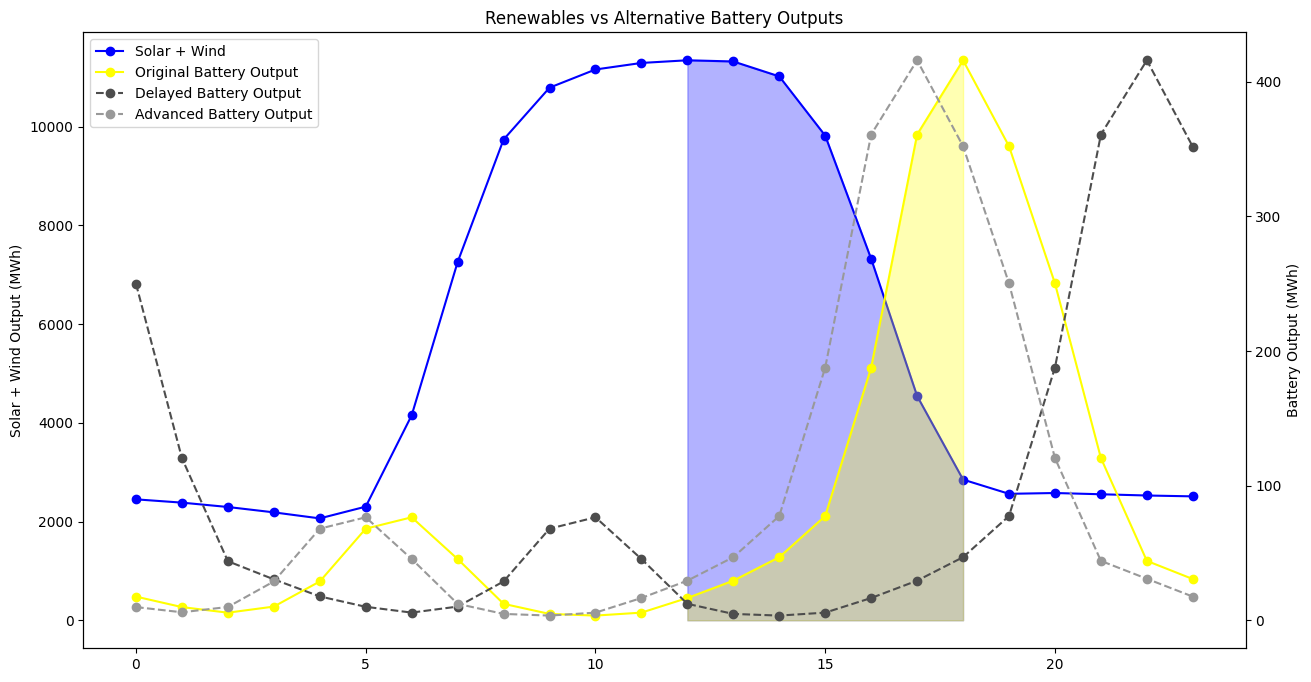

In [22]:
import matplotlib.pyplot as plt

# Aggregate data by hour
hourly_df = shifted_df.groupby('hour').mean()

plt.figure(figsize=(15, 8   ))

# Create the first y-axis
ax1 = plt.gca()

# Plot the solar_wind data on the first y-axis
solar_wind_line, = ax1.plot(hourly_df.index, hourly_df['solar_wind'], color='blue', marker='o', label='Solar + Wind')
ax1.set_ylabel('Solar + Wind Output (MWh)', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a twin y-axis
ax2 = ax1.twinx()

# Plot the battery output data on the second y-axis
battery_output_line, = ax2.plot(hourly_df.index, hourly_df['battery_output'], color='yellow', marker='o', label='Original Battery Output')
backward_battery_line, = ax2.plot(hourly_df.index, hourly_df['battery_output_alternative_backward'], color='0.3', linestyle='--', marker='o', label='Backward-Shifted Battery Output')
forward_battery_line, = ax2.plot(hourly_df.index, hourly_df['battery_output_alternative_forward'], color='0.6', linestyle='--', marker='o', label='Forward-Shifted Battery Output')
ax2.set_ylabel('Battery Output (MWh)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Set the x-axis label
plt.xlabel('Hour of the Day')

# Set the title
plt.title('Renewables vs Alternative Battery Outputs')

# Shade between 12H and 18H
ax1.fill_between(hourly_df.index, hourly_df['solar_wind'], where=(hourly_df.index >= 12) & (hourly_df.index <= 18), color='blue', alpha=0.3)
ax2.fill_between(hourly_df.index, hourly_df['battery_output'], where=(hourly_df.index >= 12) & (hourly_df.index <= 18), color='yellow', alpha=0.3)

# Combine legends
plt.legend([solar_wind_line, battery_output_line, backward_battery_line, forward_battery_line],
           ['Solar + Wind', 'Original Battery Output', 'Delayed Battery Output', 'Advanced Battery Output'],
           loc='upper left')

# Show the plot
plt.show()


### **Part IV**: Logit model for predicting profitability using renewable percentage


1.   Taking into account the controled variables, the average renewable percentage (renewable output/demand) is quite effective at predicting profitability of battery, with Accuracy = 0.87; Precision = 0.87 and F1 Score = 0.89



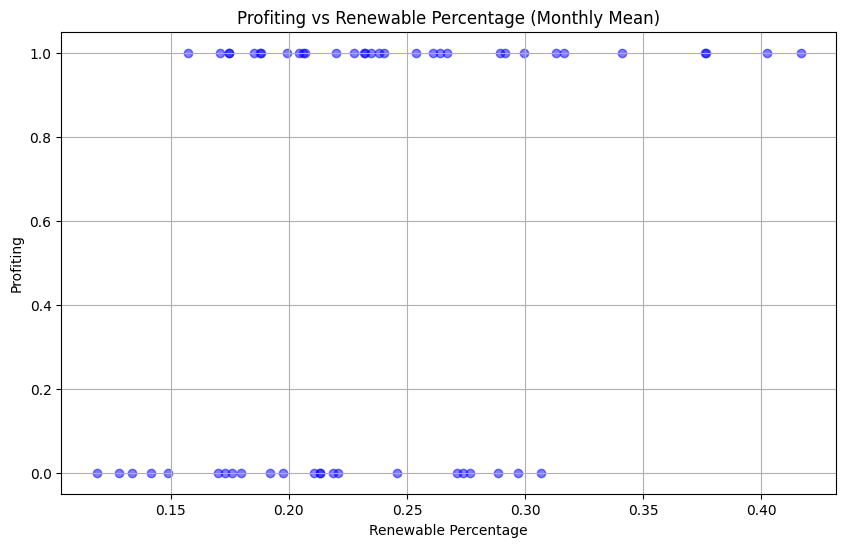

In [23]:
# Group by month and calculate the mean of each column
monthly_mean = df.groupby(df['date'].dt.to_period('M')).mean()
monthly_mean['profit_month'] = (monthly_mean['battery_revenue'] > monthly_mean['battery_cost']).astype(int)


# Plot profiting against renewable_percentage
plt.figure(figsize=(10, 6))
plt.scatter(monthly_mean['renewable_percentage'], monthly_mean['profit_month'], color='blue', alpha=0.5)
plt.title('Profiting vs Renewable Percentage (Monthly Mean)')
plt.xlabel('Renewable Percentage')
plt.ylabel('Profiting')
plt.grid(True)
plt.show()


In [24]:
control_variables = ['coal', 'nuclear', 'largehydro', 'load_dayaheadfc']

# Define independent variable (features)
X = monthly_mean[['renewable_percentage'] + control_variables]

# Define dependent variable (target)
y = monthly_mean['profit_month']

# Add fixed effects
X = sm.add_constant(X)

# Fit logistic regression model
logit_model = sm.Logit(y, X)
logit_result = logit_model.fit()

# Print summary of regression results
print(logit_result.summary())


Optimization terminated successfully.
         Current function value: 0.294439
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:           profit_month   No. Observations:                   55
Model:                          Logit   Df Residuals:                       49
Method:                           MLE   Df Model:                            5
Date:                Fri, 02 Aug 2024   Pseudo R-squ.:                  0.5668
Time:                        17:48:02   Log-Likelihood:                -16.194
converged:                       True   LL-Null:                       -37.383
Covariance Type:            nonrobust   LLR p-value:                 4.938e-08
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -20.0540      7.525     -2.665      0.008     -34.804      -5.304

In [25]:
# Make predictions
predictions = logit_result.predict(X)
predicted_classes = (predictions > 0.5).astype(int)  # Convert probabilities to binary classes

# Calculate confusion matrix
conf_matrix = confusion_matrix(y, predicted_classes)

# Extract values from confusion matrix
true_negative = conf_matrix[0, 0]
false_positive = conf_matrix[0, 1]
false_negative = conf_matrix[1, 0]
true_positive = conf_matrix[1, 1]

# Print confusion matrix and classification metrics
print("Confusion Matrix:")
print(conf_matrix)
print("\nTrue Positive:", true_positive)
print("True Negative:", true_negative)
print("False Positive:", false_positive)
print("False Negative:", false_negative)

Confusion Matrix:
[[19  4]
 [ 3 29]]

True Positive: 29
True Negative: 19
False Positive: 4
False Negative: 3


In [26]:
# Calculate accuracy
accuracy = (true_positive + true_negative) / np.sum(conf_matrix)

# Calculate precision
precision = true_positive / (true_positive + false_positive)

# Calculate recall (or sensitivity)
recall = true_positive / (true_positive + false_negative)

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


Accuracy: 0.8727272727272727
Precision: 0.8787878787878788
Recall: 0.90625
F1 Score: 0.8923076923076922


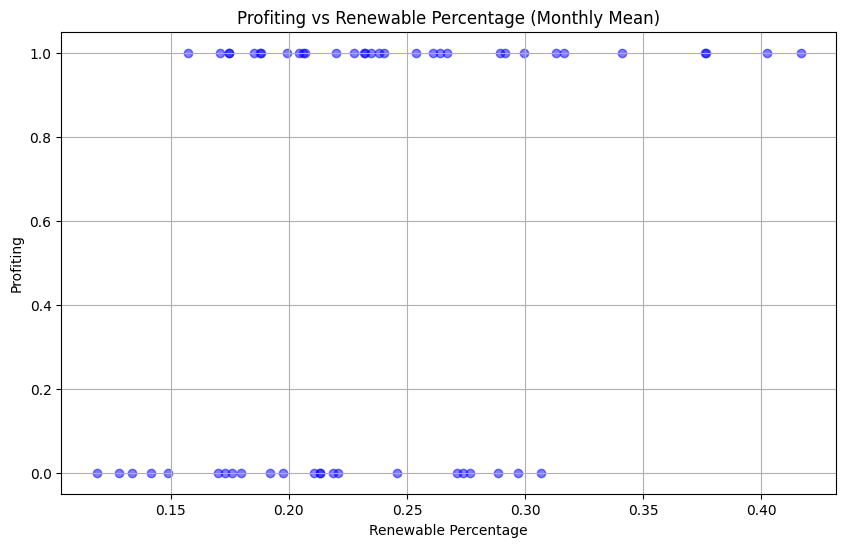

In [27]:
# Group by month and calculate the mean of each column
daily_mean = df.groupby(df['date']).mean()

# Plot profiting against renewable_percentage
plt.figure(figsize=(10, 6))
plt.scatter(monthly_mean['renewable_percentage'], monthly_mean['profit_month'], color='blue', alpha=0.5)
plt.title('Profiting vs Renewable Percentage (Monthly Mean)')
plt.xlabel('Renewable Percentage')
plt.ylabel('Profiting')
plt.grid(True)
plt.show()


In [28]:
control_variables = ['coal', 'nuclear', 'largehydro', 'load_dayaheadfc']

# Define independent variable (features)
X = daily_mean[['renewable_percentage'] + control_variables]

# Define dependent variable (target)
y = daily_mean['profiting']

# Add fixed effects
X = sm.add_constant(X)

# Fit logistic regression model
logit_model = sm.Logit(y, X)
logit_result = logit_model.fit()

# Print summary of regression results
print(logit_result.summary())


Optimization terminated successfully.
         Current function value: 0.663270
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:              profiting   No. Observations:                 1665
Model:                          Logit   Df Residuals:                     1659
Method:                           MLE   Df Model:                            5
Date:                Fri, 02 Aug 2024   Pseudo R-squ.:                 -0.2295
Time:                        17:48:12   Log-Likelihood:                -1104.3
converged:                       True   LL-Null:                       -898.20
Covariance Type:            nonrobust   LLR p-value:                     1.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0750      0.449      0.167      0.867      -0.804       0.954